In [2]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
import statsmodels.api as sm
import random
from sklearn.metrics import precision_recall_curve, roc_curve
from itertools import combinations, product
import matplotlib
import csv

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:

#ped_file = '../../DATA/ihart.ms2/ihart.ped'
#phase_dir = '../phased_ihart.ms2_del'
#sim_file = '../sibpair_similarity/ihart.ms2_del_similarity.txt'

ped_file = '../../DATA/ihart.ms2/ihart.ped'
phase_dir = '../phased_ihart.ms2_quads_del'
sim_file = '../sibpair_similarity/ihart.ms2_quads_del_similarity.txt'

#ped_file = '../../DATA/spark/spark.ped'
#phase_dir = '../phased_spark_del'
#sim_file = '../sibpair_similarity/spark_del_similarity.txt'

ssc_ped_file = '../../DATA/ssc.hg38/ssc.ped'
ssc_phase_dir = '../phased_ssc.hg38_del'
ssc_sim_file = '../sibpair_similarity/ssc.hg38_del_similarity.txt'


In [4]:
colors=['#ef6c00', '#4db6ac', '#ce93d8ff']

In [5]:
def get_data(ped_file, phase_dir, sim_file):
    sibpair_to_sim = dict()
    with open(sim_file, 'r') as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            sibpair_to_sim[(pieces[0], tuple(sorted([pieces[1], pieces[2]])))] = (float(pieces[3]), float(pieces[4]))

    # pull affected status
    # (0=unknown; 1=unaffected; 2=affected)
    child_id_to_affected = dict()
    child_id_to_sex = dict()
    fam_to_inds = dict()
    in_ped = set()
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

                if f_id != '0' and m_id != '0':
                    if (fam_id, m_id, f_id) not in fam_to_inds:
                        fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
                    fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
                in_ped.add(m_id)
                in_ped.add(f_id)
                in_ped.add(child_id)

    print('ped loaded')
    print('children', len(child_id_to_affected))

    with open('%s/deletions.json' % phase_dir) as f:
        deletions = json.load(f)

    # filter deletions
    deletions = [d for d in deletions if d['length']>=100]
    print('remaining deletions', len(deletions))
    #
    deletions = [d for d in deletions if d['is_inherited']]
    print('remaining deletions', len(deletions))

    return fam_to_inds, child_id_to_affected, child_id_to_sex, deletions, sibpair_to_sim

fam_to_inds, child_id_to_affected, child_id_to_sex, deletions, sibpair_to_sim = get_data(ped_file, phase_dir, sim_file)
ssc_fam_to_inds, ssc_child_id_to_affected, ssc_child_id_to_sex, ssc_deletions, ssc_sibpair_to_sim = get_data(ssc_ped_file, ssc_phase_dir, ssc_sim_file)

ped loaded
children 4611
remaining deletions 329201
remaining deletions 329201
ped loaded
children 9371
remaining deletions 466955
remaining deletions 466955


No handles with labels found to put in legend.


Mat/Pat ihart Ttest_indResult(statistic=28.170170105361827, pvalue=2.1900445238846384e-174)


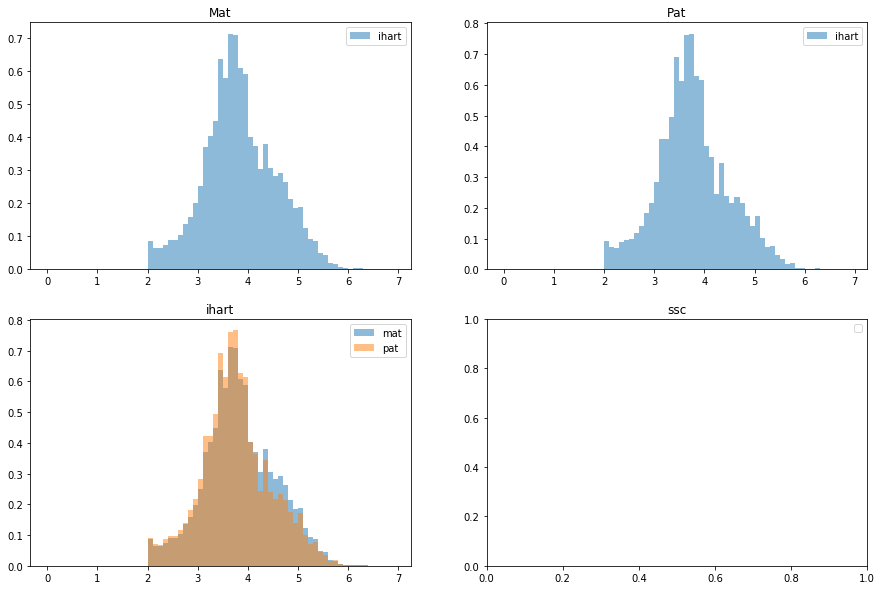

In [6]:
bins=np.arange(0, 7, 0.1)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(np.log10([d['length'] for d in deletions if d['is_mat']]), alpha=0.5, bins=bins, density=True, label='ihart')
#plt.hist(np.log10([d['length'] for d in ssc_deletions if d['is_mat']]), alpha=0.5, bins=bins, density=True, label='ssc')
plt.legend()
plt.title('Mat')

plt.subplot(2, 2, 2)
plt.hist(np.log10([d['length'] for d in deletions if d['is_pat']]), alpha=0.5, bins=bins, density=True, label='ihart')
#plt.hist(np.log10([d['length'] for d in ssc_deletions if d['is_pat']]), alpha=0.5, bins=bins, density=True, label='ssc')
plt.legend()
plt.title('Pat')

#print('Mat ihart/ssc', stats.ttest_ind(np.log10([d['length'] for d in deletions if d['is_mat']]), 
#                      np.log10([d['length'] for d in ssc_deletions if d['is_mat']])))
#print('Pat ihart/ssc', stats.ttest_ind(np.log10([d['length'] for d in deletions if d['is_pat']]), 
#                      np.log10([d['length'] for d in ssc_deletions if d['is_pat']])))

plt.subplot(2, 2, 3)
plt.hist(np.log10([d['length'] for d in deletions if d['is_mat']]), alpha=0.5, bins=bins, density=True, label='mat')
plt.hist(np.log10([d['length'] for d in deletions if d['is_pat']]), alpha=0.5, bins=bins, density=True, label='pat')
plt.legend()
plt.title('ihart')

plt.subplot(2, 2, 4)
#plt.hist(np.log10([d['length'] for d in ssc_deletions if d['is_mat']]), alpha=0.5, bins=bins, density=True, label='mat')
#plt.hist(np.log10([d['length'] for d in ssc_deletions if d['is_pat']]), alpha=0.5, bins=bins, density=True, label='pat')
plt.legend()
plt.title('ssc')

print('Mat/Pat ihart', stats.ttest_ind(np.log10([d['length'] for d in deletions if d['is_mat']]), 
                      np.log10([d['length'] for d in deletions if d['is_pat']])))
#print('Mat/Pat ssc', stats.ttest_ind(np.log10([d['length'] for d in ssc_deletions if d['is_mat']]), 
#                      np.log10([d['length'] for d in ssc_deletions if d['is_pat']])))
plt.show()


In [7]:
def get_mad_outliers(x):
    median = np.median(x, axis=0)
    diff = np.abs(x - median)
    mad = np.median(diff)
    
    is_outlier = 0.6745 * diff/mad > 4
    
    #plt.hist([x[~is_outlier], x[is_outlier]], stacked=True)
    #plt.show()
    
    return is_outlier

def get_matches(fam_to_inds, child_id_to_affected, child_id_to_sex, deletions, sibpair_to_sim):
    
    sibpairs = sorted(sibpair_to_sim.keys())
    reverse_sibpairs = [(fam, x) for (fam, x) in sibpairs if child_id_to_affected[x[0]] in ['1', '2'] and \
                   child_id_to_affected[x[1]] in ['1', '2'] and (child_id_to_affected[x[0]]=='1' or child_id_to_affected[x[1]]=='1')]
    sibpairs = [(fam, x) for (fam, x) in sibpairs if child_id_to_affected[x[0]] in ['1', '2'] and \
                   child_id_to_affected[x[1]] in ['1', '2'] and (child_id_to_affected[x[0]]=='2' or child_id_to_affected[x[1]]=='2')]
    
    print('sibpairs', len(sibpairs), 'reverse_sibpairs', len(reverse_sibpairs))
    
    probands, siblings = [], []
    reverse_probands, reverse_siblings = [], []
    child_to_proband_indices = defaultdict(list)
    child_to_sibling_indices = defaultdict(list)
    reverse_child_to_proband_indices = defaultdict(list)
    reverse_child_to_sibling_indices = defaultdict(list)
    
    for i, (fam, (sib1, sib2)) in enumerate(sibpairs):
        if child_id_to_affected[sib1]=='2' and child_id_to_affected[sib2]=='2':
            sibs = [sib1, sib2]
            random.shuffle(sibs)
            proband, sibling = sibs
        elif child_id_to_affected[sib1]=='2':
            proband, sibling = sib1, sib2
        else:
            proband, sibling = sib2, sib1
        
        probands.append((fam, proband))
        siblings.append((fam, sibling))
        child_to_proband_indices[(fam, proband)].append(i)
        child_to_sibling_indices[(fam, sibling)].append(i)
            
    for i, (fam, (sib1, sib2)) in enumerate(reverse_sibpairs):
        if child_id_to_affected[sib1]=='1' and child_id_to_affected[sib2]=='1':
            sibs = [sib1, sib2]
            random.shuffle(sibs)
            proband, sibling = sibs
        elif child_id_to_affected[sib1]=='1':
            proband, sibling = sib1, sib2
        else:
            proband, sibling = sib2, sib1
        
        reverse_probands.append((fam, proband))
        reverse_siblings.append((fam, sibling))
        reverse_child_to_proband_indices[(fam, proband)].append(i)
        reverse_child_to_sibling_indices[(fam, sibling)].append(i)
    
    assert (len(probands) == len(sibpairs)) and (len(siblings) == len(sibpairs))
    assert (len(reverse_probands) == len(reverse_sibpairs)) and (len(reverse_siblings) == len(reverse_sibpairs))
    
    sibpair_to_index = dict([(x, i) for i, x in enumerate(sibpairs)])
    reverse_sibpair_to_index = dict([(x, i) for i, x in enumerate(reverse_sibpairs)])  
    
    # sibpair, mat/pat
    sim = np.array([sibpair_to_sim[x][:2] for x in sibpairs])
    reverse_sim = np.array([sibpair_to_sim[x][:2] for x in reverse_sibpairs])
                      
    # sibpair, mat/pat
    deletions_match = np.zeros((len(sibpairs), 2), dtype=int)    
    reverse_deletions_match = np.zeros((len(reverse_sibpairs), 2), dtype=int)  
    
    # child, mat/pat
    children = sorted(set(probands) | set(siblings) | set(reverse_probands) | set(reverse_siblings))
    child_to_index = dict([(x, i) for i, x in enumerate(children)])
    child_deletions = np.zeros((len(children), 2), dtype=int) 
    
    for d in deletions:
        for sib1, sib2 in combinations(d['trans'], 2):
            key = (d['family'], tuple(sorted([sib1, sib2])))
            if key in sibpair_to_index:
                deletions_match[sibpair_to_index[key], int(d['is_pat'])] += d['length']
            if key in reverse_sibpair_to_index:
                reverse_deletions_match[reverse_sibpair_to_index[key], int(d['is_pat'])] += d['length']
        
        for child in d['trans']:
            key = (d['family'], child)
            if key in child_to_index:
                child_deletions[child_to_index[key], int(d['is_pat'])] += d['length']
            
    is_outlier = np.zeros((len(sibpairs),), dtype=bool)    
    for key, x in [('sim', sim)]:#, ('deletions_match', np.log10(deletions_match))]:
        mat_outliers = get_mad_outliers(x[:, 0])
        pat_outliers = get_mad_outliers(x[:, 1])
        
        print(key, 'outliers', np.sum(mat_outliers), np.sum(pat_outliers))
        
        is_outlier[mat_outliers | pat_outliers] = True

    reverse_is_outlier = np.zeros((len(reverse_sibpairs),), dtype=bool)
    for key, x in [('sim', reverse_sim)]:#, ('deletions_match', np.log10(reverse_deletions_match))]:
        mat_outliers = get_mad_outliers(x[:, 0])
        pat_outliers = get_mad_outliers(x[:, 1])
        
        print(key, 'outliers', np.sum(mat_outliers), np.sum(pat_outliers))
        
        reverse_is_outlier[mat_outliers | pat_outliers] = True
        
    child_is_outlier = get_mad_outliers(np.log10(child_deletions[:, 0])) | get_mad_outliers(np.log10(child_deletions[:, 1]))
    print('child outliers', np.sum(child_is_outlier))
    for i in np.where(child_is_outlier)[0]:
        is_outlier[child_to_proband_indices[children[i]]] = True
        is_outlier[child_to_sibling_indices[children[i]]] = True
        reverse_is_outlier[reverse_child_to_proband_indices[children[i]]] = True
        reverse_is_outlier[reverse_child_to_sibling_indices[children[i]]] = True
        
    proband_deletions = np.zeros((len(sibpairs), 2), dtype=int) 
    reverse_proband_deletions = np.zeros((len(reverse_sibpairs), 2), dtype=int)
    sibling_deletions = np.zeros((len(sibpairs), 2), dtype=int) 
    reverse_sibling_deletions = np.zeros((len(reverse_sibpairs), 2), dtype=int) 

    for child, indices in child_to_proband_indices.items():
        proband_deletions[indices, :] = child_deletions[child_to_index[child], :]
    for child, indices in child_to_sibling_indices.items():
        sibling_deletions[indices, :] = child_deletions[child_to_index[child], :]
    for child, indices in reverse_child_to_proband_indices.items():
        reverse_proband_deletions[indices, :] = child_deletions[child_to_index[child], :]
    for child, indices in reverse_child_to_sibling_indices.items():
        reverse_sibling_deletions[indices, :] = child_deletions[child_to_index[child], :]
        
    sibpairs = [x for x, b in zip(sibpairs, is_outlier) if not b]
    probands = [x for x, b in zip(probands, is_outlier) if not b]
    siblings = [x for x, b in zip(siblings, is_outlier) if not b]
    sim = sim[~is_outlier, :]
    deletions_match = deletions_match[~is_outlier, :]
    proband_deletions = proband_deletions[~is_outlier, :]
    sibling_deletions = sibling_deletions[~is_outlier, :]
    
    reverse_sibpairs = [x for x, b in zip(reverse_sibpairs, reverse_is_outlier) if not b]
    reverse_probands = [x for x, b in zip(reverse_probands, reverse_is_outlier) if not b]
    reverse_siblings = [x for x, b in zip(reverse_siblings, reverse_is_outlier) if not b]
    reverse_sim = reverse_sim[~reverse_is_outlier, :]
    reverse_deletions_match = reverse_deletions_match[~reverse_is_outlier, :]
    reverse_proband_deletions = reverse_proband_deletions[~reverse_is_outlier, :]
    reverse_sibling_deletions = reverse_sibling_deletions[~reverse_is_outlier, :]
    
    is_aut_aut = np.array([child_id_to_affected[sib1]=='2' and child_id_to_affected[sib2]=='2' for fam, (sib1, sib2) in sibpairs])
    reverse_is_nt_nt = np.array([child_id_to_affected[sib1]=='1' and child_id_to_affected[sib2]=='1' for fam, (sib1, sib2) in reverse_sibpairs])

    proband_is_f = np.array([child_id_to_sex[x]=='2' for fam, x in probands])
    sibling_is_f = np.array([child_id_to_sex[x]=='2' for fam, x in siblings])
    reverse_proband_is_f = np.array([child_id_to_sex[x]=='2' for fam, x in reverse_probands])
    reverse_sibling_is_f = np.array([child_id_to_sex[x]=='2' for fam, x in reverse_siblings])
            
    return sibpairs, probands, siblings, sim, deletions_match, proband_deletions, sibling_deletions, \
            is_aut_aut, proband_is_f, sibling_is_f, \
            reverse_sibpairs, reverse_sim, reverse_deletions_match, reverse_proband_deletions, reverse_sibling_deletions, \
            reverse_is_nt_nt, reverse_proband_is_f, reverse_sibling_is_f

sibpairs, probands, siblings, sim, deletions_match, proband_deletions, sibling_deletions, \
            is_aut_aut, proband_is_f, sibling_is_f, \
            reverse_sibpairs, reverse_sim, reverse_deletions_match, reverse_proband_deletions, reverse_sibling_deletions, \
            reverse_is_nt_nt, reverse_proband_is_f, reverse_sibling_is_f = get_matches(fam_to_inds, child_id_to_affected, child_id_to_sex, deletions, sibpair_to_sim)

ssc_sibpairs, ssc_probands, ssc_siblings, ssc_sim, ssc_deletions_match, ssc_proband_deletions, ssc_sibling_deletions, \
            ssc_is_aut_aut, ssc_proband_is_f, ssc_sibling_is_f, \
            ssc_reverse_sibpairs, ssc_reverse_sim, ssc_reverse_deletions_match, ssc_reverse_proband_deletions, ssc_reverse_sibling_deletions, \
            ssc_reverse_is_nt_nt, ssc_reverse_proband_is_f, ssc_reverse_sibling_is_f = get_matches(ssc_fam_to_inds, ssc_child_id_to_affected, ssc_child_id_to_sex, ssc_deletions, ssc_sibpair_to_sim)


sibpairs 2044 reverse_sibpairs 941
sim outliers 115 109
sim outliers 11 9
child outliers 32
sibpairs 1925 reverse_sibpairs 1925


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:110: RuntimeWarning: divide by zero encountered in log10


sim outliers 2 1
sim outliers 2 1
child outliers 13


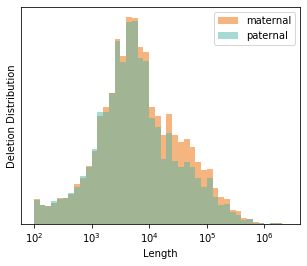

In [8]:
bins=np.arange(2, 6.5, 0.1)

plt.figure(figsize=(5, 4))

plt.hist(np.log10([d['length'] for d in deletions if d['is_mat']]), alpha=0.5, bins=bins, label='maternal', color=colors[0])
plt.hist(np.log10([d['length'] for d in deletions if d['is_pat']]), alpha=0.5, bins=bins, label='paternal', color=colors[1])
plt.legend()
#plt.title('Deletion Lengths')
plt.xticks(np.arange(2, 7), ['$10^{%d}$' % d for d in np.arange(2, 7)])
plt.yticks([])
plt.ylabel('Deletion Distribution')
plt.xlabel('Length')
plt.show()


In [9]:
print(sibpairs[0])

('AU0012.AU001203.AU001204', ('AU001203', 'AU001204'))


In [10]:
# pick independent sibpairs
ind_probands = set()
for fam, inds in fam_to_inds.items():
    aut_children = [x for x in inds[2:] if child_id_to_affected[x]=='2']
    if len(aut_children)> 0:
        ind_probands.add(random.choice(aut_children))
print(len(ind_probands))

is_ind_sibpair = np.array([x[0] in ind_probands or x[1] in ind_probands for f, x in sibpairs])
print(np.sum(is_ind_sibpair))

1038
1307


No handles with labels found to put in legend.


Mat/Pat ihart Ttest_indResult(statistic=1.4829531972011933, pvalue=0.13816882383665596)


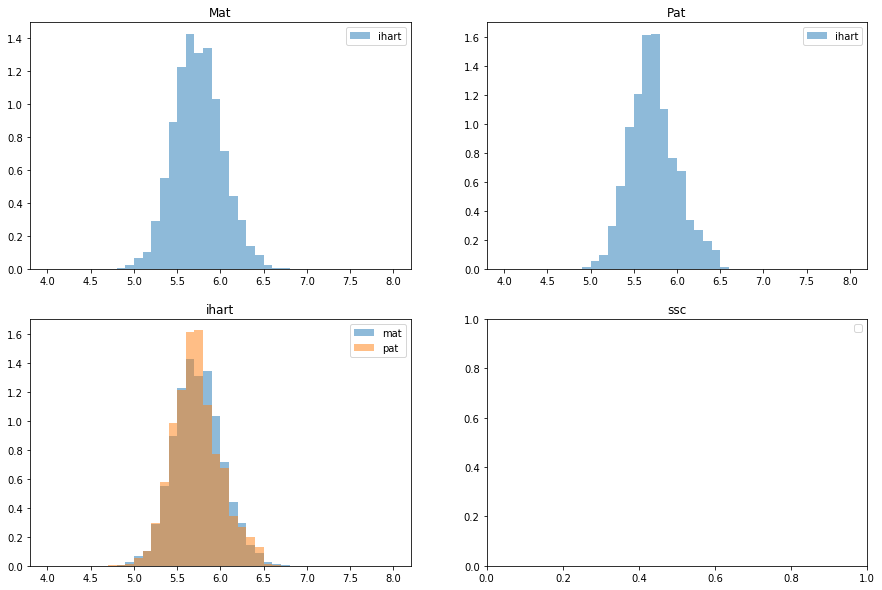

In [11]:
bins=np.arange(4, 8.1, 0.1)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(np.clip(np.log10(deletions_match[:, 0]), 4, 8), alpha=0.5, bins=bins, density=True, label='ihart')
#plt.hist(np.clip(np.log10(ssc_deletions_match[:, 0]), 4, 8), alpha=0.5, bins=bins, density=True, label='ssc')
plt.legend()
plt.title('Mat')

plt.subplot(2, 2, 2)
plt.hist(np.clip(np.log10(deletions_match[:, 1]), 4, 8), alpha=0.5, bins=bins, density=True, label='ihart')
#plt.hist(np.clip(np.log10(ssc_deletions_match[:, 1]), 4, 8), alpha=0.5, bins=bins, density=True, label='ssc')
plt.legend()
plt.title('Pat')

#print('Mat ihart/ssc', stats.ttest_ind(np.log10(deletions_match[:, 0]), np.log10(ssc_deletions_match[:, 0])))
#print('Pat ihart/ssc', stats.ttest_ind(np.log10(deletions_match[:, 1]), np.log10(ssc_deletions_match[:, 1])))


plt.subplot(2, 2, 3)
plt.hist(np.clip(np.log10(deletions_match[:, 0]), 4, 8), alpha=0.5, bins=bins, density=True, label='mat')
plt.hist(np.clip(np.log10(deletions_match[:, 1]), 4, 8), alpha=0.5, bins=bins, density=True, label='pat')
plt.legend()
plt.title('ihart')

plt.subplot(2, 2, 4)
#plt.hist(np.clip(np.log10(ssc_deletions_match[:, 0]), 4, 8), alpha=0.5, bins=bins, density=True, label='mat')
#plt.hist(np.clip(np.log10(ssc_deletions_match[:, 1]), 4, 8), alpha=0.5, bins=bins, density=True, label='pat')
plt.legend()
plt.title('ssc')

print('Mat/Pat ihart', stats.ttest_ind(np.log10(deletions_match[:, 0]), np.log10(deletions_match[:, 1])))
#print('Mat/Pat ssc', stats.ttest_ind(np.log10(ssc_deletions_match[:, 0]), np.log10(ssc_deletions_match[:, 1])))

plt.show()


(0.1616607241010935, 9.928336820465911e-13)
(0.25017687550013307, 7.899479213164122e-29)
(-0.0006710374297732269, 0.9765398152852582)
(-0.027926612053343066, 0.22092170948482717)


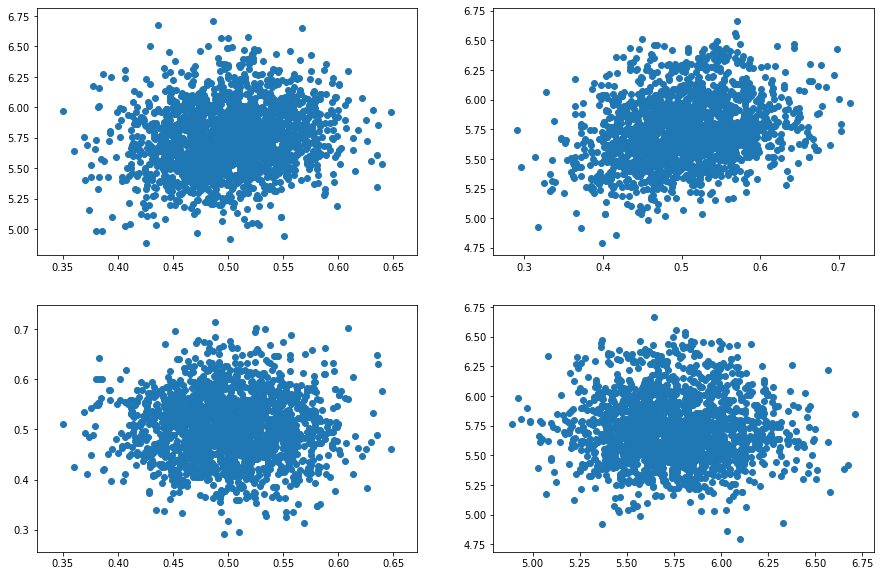

In [12]:
#print(np.var(mat_sim[mat_has_data]), np.var(mat_jaccard[mat_has_data]))
#print(np.var(pat_sim[pat_has_data]), np.var(pat_jaccard[pat_has_data]))

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.scatter(sim[:, 0], np.log10(deletions_match[:, 0]))
print(stats.pearsonr(sim[:, 0], np.log10(deletions_match[:, 0])))
#plt.xlim([0, 1])

plt.subplot(2, 2, 2)
plt.scatter(sim[:, 1], np.log10(deletions_match[:, 1]))
print(stats.pearsonr(sim[:, 1], np.log10(deletions_match[:, 1])))
#plt.xlim([0, 1])

plt.subplot(2, 2, 3)
plt.scatter(sim[:, 0], sim[:, 1])
print(stats.pearsonr(sim[:, 0], sim[:, 1]))
#plt.xlim([0, 1])
#plt.ylim([0, 1])

plt.subplot(2, 2, 4)
plt.scatter(np.log10(deletions_match[:, 0]), np.log10(deletions_match[:, 1]))
print(stats.pearsonr(np.log10(deletions_match[:, 0]), np.log10(deletions_match[:, 1])))


plt.show()

In [13]:
print(np.sum(proband_is_f), np.sum(sibling_is_f), np.sum(proband_is_f & sibling_is_f))

465 724 204


In [14]:
print(sim.shape, proband_is_f.shape)

(1923, 2) (1923,)


Optimization terminated successfully.
         Current function value: 0.652613
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1923
Model:                          Logit   Df Residuals:                     1917
Method:                           MLE   Df Model:                            5
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:                 0.05228
Time:                        09:54:47   Log-Likelihood:                -1255.0
converged:                       True   LL-Null:                       -1324.2
Covariance Type:            nonrobust   LLR p-value:                 3.814e-28
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9936      1.024      0.970      0.332      -1.014       3.001
x2             1.0979      0.

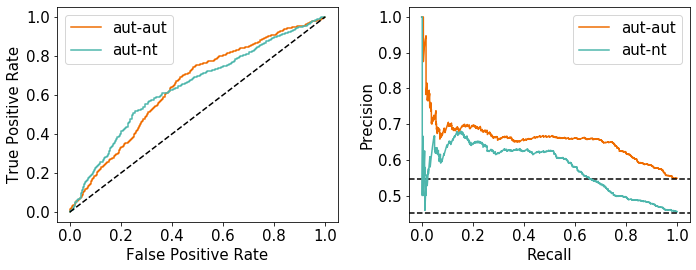

In [15]:
X = np.vstack((sim.T,
               #mat_Xsim,
               #is_m_m, is_m_f, is_f_f
               proband_is_f * sibling_is_f, 
               proband_is_f * ~sibling_is_f, 
               ~proband_is_f * sibling_is_f, 
               ~proband_is_f * ~sibling_is_f, 
              )).T
y = is_aut_aut

model = sm.Logit(y, X)
result = model.fit()
print(result.summary())

matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
#sensitivity, specificity, _ = roc_curve(y==2, result.predict(X)[:, 2])
#plt.plot(sensitivity, specificity, label='aut-aut')

sensitivity, specificity, _ = roc_curve(y==1, result.predict(X))
plt.plot(sensitivity, specificity, label='aut-aut', color=colors[0])
sensitivity, specificity, _ = roc_curve(y==0, 1-result.predict(X))
plt.plot(sensitivity, specificity, label='aut-nt', color=colors[1])

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.subplot(1, 2, 2)
#precision, recall, _ = precision_recall_curve(y==2, result.predict(X)[:, 2])
#plt.plot(recall, precision, label='aut-aut')
#plt.axhline(np.sum(y==2)/len(y), color='black', linestyle='--')

precision, recall, _ = precision_recall_curve(y==1, result.predict(X))
plt.plot(recall, precision, label='aut-aut', color=colors[0])
plt.axhline(np.sum(y==1)/len(y), color='black', linestyle='--')

precision, recall, _ = precision_recall_curve(y==0, 1-result.predict(X))
plt.plot(recall, precision, label='aut-nt', color=colors[1])
plt.axhline(np.sum(y==0)/len(y), color='black', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')



plt.legend()

plt.tight_layout()
plt.show()

baseline_result = result
baseline_X = X
baseline_y = y

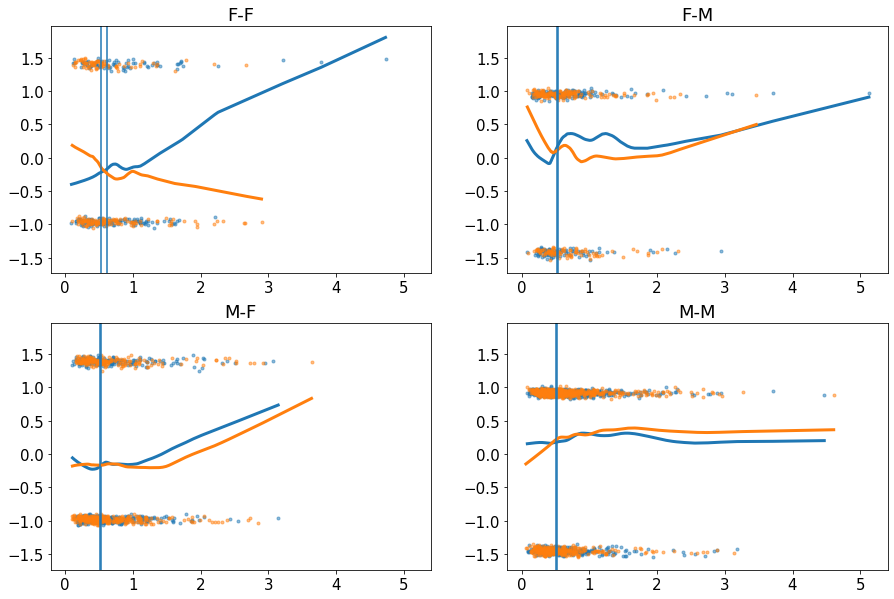

In [16]:

plt.figure(figsize=(15, 10))
ax = plt.subplot(2, 2, 1)
plt.scatter(deletions_match[proband_is_f & sibling_is_f, 0]/1000000, 
            baseline_result.resid_dev[proband_is_f & sibling_is_f], alpha=0.5, marker='.')
l = sm.nonparametric.lowess(baseline_result.resid_dev[proband_is_f & sibling_is_f], 
                                       deletions_match[proband_is_f & sibling_is_f, 0]/1000000, return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3)
plt.axvline(np.median(deletions_match[proband_is_f & sibling_is_f, 0]/1000000))

plt.scatter(deletions_match[proband_is_f & sibling_is_f, 1]/1000000, 
            baseline_result.resid_dev[proband_is_f & sibling_is_f], alpha=0.5, marker='.')
l = sm.nonparametric.lowess(baseline_result.resid_dev[proband_is_f & sibling_is_f], 
                                       deletions_match[proband_is_f & sibling_is_f, 1]/1000000, return_sorted=True)

plt.plot(l[:, 0], l[:, 1], linewidth=3)
plt.axvline(np.median(deletions_match[proband_is_f & sibling_is_f, 1]/1000000))
plt.title('F-F')

plt.subplot(2, 2, 2, sharex=ax, sharey=ax)
plt.scatter(deletions_match[proband_is_f & ~sibling_is_f, 0]/1000000, 
            baseline_result.resid_dev[proband_is_f & ~sibling_is_f], alpha=0.5, marker='.')
l = sm.nonparametric.lowess(baseline_result.resid_dev[proband_is_f & ~sibling_is_f], 
                                       deletions_match[proband_is_f & ~sibling_is_f, 0]/1000000, return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3)
plt.axvline(np.median(deletions_match[proband_is_f & ~sibling_is_f, 0]/1000000))

plt.scatter(deletions_match[proband_is_f & ~sibling_is_f, 1]/1000000, 
            baseline_result.resid_dev[proband_is_f & ~sibling_is_f], alpha=0.5, marker='.')
l = sm.nonparametric.lowess(baseline_result.resid_dev[proband_is_f & ~sibling_is_f], 
                                       deletions_match[proband_is_f & ~sibling_is_f, 1]/1000000, return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3)
plt.axvline(np.median(deletions_match[proband_is_f & ~sibling_is_f, 1]/1000000))
plt.title('F-M')

plt.subplot(2, 2, 3, sharex=ax, sharey=ax)
plt.scatter(deletions_match[~proband_is_f & sibling_is_f, 0]/1000000, 
            baseline_result.resid_dev[~proband_is_f & sibling_is_f], alpha=0.5, marker='.')
l = sm.nonparametric.lowess(baseline_result.resid_dev[~proband_is_f & sibling_is_f], 
                                       deletions_match[~proband_is_f & sibling_is_f, 0]/1000000, return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3)
plt.axvline(np.median(deletions_match[~proband_is_f & sibling_is_f, 0]/1000000))

plt.scatter(deletions_match[~proband_is_f & sibling_is_f, 1]/1000000, 
            baseline_result.resid_dev[~proband_is_f & sibling_is_f], alpha=0.5, marker='.')
l = sm.nonparametric.lowess(baseline_result.resid_dev[~proband_is_f & sibling_is_f], 
                                       deletions_match[~proband_is_f & sibling_is_f, 1]/1000000, return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3)
plt.axvline(np.median(deletions_match[~proband_is_f & sibling_is_f, 1]/1000000))
plt.title('M-F')

plt.subplot(2, 2, 4, sharex=ax, sharey=ax)
plt.scatter(deletions_match[~proband_is_f & ~sibling_is_f, 0]/1000000, 
            baseline_result.resid_dev[~proband_is_f & ~sibling_is_f], alpha=0.5, marker='.')
l = sm.nonparametric.lowess(baseline_result.resid_dev[~proband_is_f & ~sibling_is_f], 
                                       deletions_match[~proband_is_f & ~sibling_is_f, 0]/1000000, return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3)
plt.axvline(np.median(deletions_match[~proband_is_f & ~sibling_is_f, 0]/1000000))

plt.scatter(deletions_match[~proband_is_f & ~sibling_is_f, 1]/1000000, 
            baseline_result.resid_dev[~proband_is_f & ~sibling_is_f], alpha=0.5, marker='.')
l = sm.nonparametric.lowess(baseline_result.resid_dev[~proband_is_f & ~sibling_is_f], 
                                       deletions_match[~proband_is_f & ~sibling_is_f, 1]/1000000, return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3)
plt.axvline(np.median(deletions_match[~proband_is_f & ~sibling_is_f, 1]/1000000))

plt.title('M-M')

plt.show()

In [17]:
print('probandF-siblingF', np.sum(proband_is_f & sibling_is_f), 
     'probandF-siblingM', np.sum(proband_is_f & ~sibling_is_f), 
     'probandM-siblingF', np.sum(~proband_is_f & sibling_is_f), 
     'probandM-siblingM', np.sum(~proband_is_f & ~sibling_is_f), )

probandF-siblingF 204 probandF-siblingM 261 probandM-siblingF 520 probandM-siblingM 938


In [18]:
print('probandF-siblingF', 'aut-aut', np.sum(is_aut_aut[proband_is_f & sibling_is_f]), 'aut-nt', np.sum(~is_aut_aut[proband_is_f & sibling_is_f]))
print('probandF-siblingM', 'aut-aut', np.sum(is_aut_aut[proband_is_f & ~sibling_is_f]), 'aut-nt', np.sum(~is_aut_aut[proband_is_f & ~sibling_is_f]))
print('probandM-siblingF', 'aut-aut', np.sum(is_aut_aut[~proband_is_f & sibling_is_f]), 'aut-nt', np.sum(~is_aut_aut[~proband_is_f & sibling_is_f]))
print('probandM-siblingM', 'aut-aut', np.sum(is_aut_aut[~proband_is_f & ~sibling_is_f]), 'aut-nt', np.sum(~is_aut_aut[~proband_is_f & ~sibling_is_f]))


probandF-siblingF aut-aut 76 aut-nt 128
probandF-siblingM aut-aut 166 aut-nt 95
probandM-siblingF aut-aut 198 aut-nt 322
probandM-siblingM aut-aut 613 aut-nt 325


In [19]:
print(deletions_match.T)

[[ 449599  637026  403783 ...  356554 1001649  466596]
 [ 461511  271951  293006 ...  385628  619226  337012]]


(1307, 8) (1307,)
899 1307
Optimization terminated successfully.
         Current function value: 0.582869
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1307
Model:                          Logit   Df Residuals:                     1299
Method:                           MLE   Df Model:                            7
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:                 0.06113
Time:                        09:54:50   Log-Likelihood:                -761.81
converged:                       True   LL-Null:                       -811.41
Covariance Type:            nonrobust   LLR p-value:                 1.571e-18
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
mat_genomic_similarity          0.0460      1.3

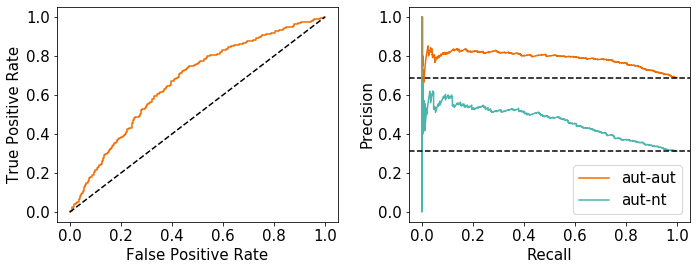

In [20]:
#from patsy import dmatrix

X = np.vstack((sim.T, 
                deletions_match.T/1000000,
                proband_is_f * sibling_is_f,
                proband_is_f * ~sibling_is_f, 
                ~proband_is_f * sibling_is_f, 
                ~proband_is_f * ~sibling_is_f, 
                  )).T[is_ind_sibpair, :]
y = is_aut_aut[is_ind_sibpair]

#X = np.vstack((mat_sim, pat_sim, mat_jaccard, pat_jaccard, np.ones((len(sibpairs), )))).T[mat_has_data & pat_has_data, :]
#y = is_aut_aut[mat_has_data & pat_has_data] | is_nt_nt[mat_has_data & pat_has_data]


print(X.shape, y.shape)
print(np.sum(y), len(y))

model = sm.Logit(y, X)
model.exog_names[:] = ['mat_genomic_similarity', 'pat_genomic_similarity',
                       'mat_match_del', 'pat_match_del',
                       'proband_is_f + sibling_is_f', 'proband_is_f + sibling_is_m',
                       'proband_is_m + sibling_is_f', 'proband_is_m + sibling_is_m',
                      ]
result = model.fit()
print(result.summary())
#print(stats.pearsonr(y, result.predict(X)), stats.pearsonr(y, result.predict(X))[0]**2)

matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
#sensitivity, specificity, _ = roc_curve(y==2, result.predict(X)[:, 2])
#plt.plot(sensitivity, specificity, label='aut-aut')
#sensitivity, specificity, _ = roc_curve(y==0, 1-result.predict(X))
#plt.plot(sensitivity, specificity, label='aut-nt')
sensitivity, specificity, _ = roc_curve(y==1, result.predict(X))
plt.plot(sensitivity, specificity, label='aut-aut', color=colors[0])

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#plt.legend()

plt.subplot(1, 2, 2)
#precision, recall, _ = precision_recall_curve(y==2, result.predict(X)[:, 2])
#plt.plot(recall, precision, label='aut-aut')
#plt.axhline(np.sum(y==2)/len(y), color='black', linestyle='--')

precision, recall, _ = precision_recall_curve(y==1, result.predict(X))
plt.plot(recall, precision, label='aut-aut', color=colors[0])
plt.axhline(np.sum(y==1)/len(y), color='black', linestyle='--')

precision, recall, _ = precision_recall_curve(y==0, 1-result.predict(X))
plt.plot(recall, precision, label='aut-nt', color=colors[1])
plt.axhline(np.sum(y==0)/len(y), color='black', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')



plt.legend()

plt.tight_layout()
plt.show()

#baseline_result = result

Optimization terminated successfully.
         Current function value: 0.649784
         Iterations 5
0.004338815080142779
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1923
Model:                          Logit   Df Residuals:                     1915
Method:                           MLE   Df Model:                            7
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:                 0.05639
Time:                        09:54:50   Log-Likelihood:                -1249.5
converged:                       True   LL-Null:                       -1324.2
Covariance Type:            nonrobust   LLR p-value:                 5.604e-29
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
mat_genomic_similarity     0.7039      1.035      0.680      0.

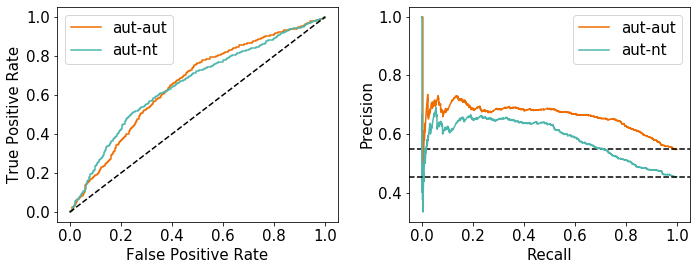

In [21]:
#from patsy import dmatrix

X = np.vstack((sim.T,
               #deletions_match[:, 0]/1000000,
               (deletions_match.T/1000000),

               #(deletions_match[:, 1]/1000000) * ~proband_is_f * ~sibling_is_f,
               #(deletions_match[:, 1]/1000000) * (proband_is_f | sibling_is_f),
               #(deletions_match[:, 1]/1000000) * sibling_is_f,
               proband_is_f * sibling_is_f,
               proband_is_f * ~sibling_is_f,
               ~proband_is_f * sibling_is_f,
               ~proband_is_f * ~sibling_is_f,
               #np.ones((len(sibpairs), ))
                  )).T
y = is_aut_aut

names = ['mat_genomic_similarity', 'pat_genomic_similarity',
    #'mat_genomic_similarity + proband_f + sibling_f', 'pat_genomic_similarity + proband_f + sibling_f',
                       #'mat_genomic_similarity + proband_f + sibling_m', 'pat_genomic_similarity + proband_f + sibling_m',
                       #'mat_genomic_similarity + proband_m + sibling_f', 'pat_genomic_similarity + proband_m + sibling_f',
                       #'mat_genomic_similarity + proband_m + sibling_m', 'pat_genomic_similarity + proband_m + sibling_m',
                       #'mat_match_del',
                       'mat_match_del', 'pat_match_del',
                       #'pat_match_del + proband_m + sibling_m',
                       #'pat_match_del + (proband_f or sibling_f)',
                       #'pat_match_del + proband_f',
                       #'pat_match_del + sibling_f',
                       'proband_f + sibling_f', 'proband_f + sibling_m', 'proband_m + sibling_f', 'proband_m + sibling_m' 
                        #'const'
                      ]
#X = np.vstack((mat_sim, pat_sim, mat_jaccard, pat_jaccard, np.ones((len(sibpairs), )))).T[mat_has_data & pat_has_data, :]
#y = is_aut_aut[mat_has_data & pat_has_data] | is_nt_nt[mat_has_data & pat_has_data]

model = sm.Logit(y, X)
model.exog_names[:] = names
result = model.fit()
pvalues = result.pvalues
        

print(stats.chi2(len(result.params)-len(baseline_result.params)).sf(-2*(baseline_result.llf-result.llf)))
print(result.summary())

matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
#sensitivity, specificity, _ = roc_curve(y==2, result.predict(X)[:, 2])
#plt.plot(sensitivity, specificity, label='aut-aut')

sensitivity, specificity, _ = roc_curve(y==1, result.predict(X))
plt.plot(sensitivity, specificity, label='aut-aut', color=colors[0])
sensitivity, specificity, _ = roc_curve(y==0, 1-result.predict(X))
plt.plot(sensitivity, specificity, label='aut-nt', color=colors[1])



plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.subplot(1, 2, 2)
#precision, recall, _ = precision_recall_curve(y==2, result.predict(X)[:, 2])
#plt.plot(recall, precision, label='aut-aut')
#plt.axhline(np.sum(y==2)/len(y), color='black', linestyle='--')

precision, recall, _ = precision_recall_curve(y==1, result.predict(X))
plt.plot(recall, precision, label='aut-aut', color=colors[0])
plt.axhline(np.sum(y==1)/len(y), color='black', linestyle='--')

precision, recall, _ = precision_recall_curve(y==0, 1-result.predict(X))
plt.plot(recall, precision, label='aut-nt', color=colors[1])
plt.axhline(np.sum(y==0)/len(y), color='black', linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')



plt.legend()

plt.tight_layout()
plt.show()

#baseline_result = result

Optimization terminated successfully.
         Current function value: 0.646652
         Iterations 5
0.003461874500527628
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1923
Model:                          Logit   Df Residuals:                     1909
Method:                           MLE   Df Model:                           13
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:                 0.06093
Time:                        09:54:51   Log-Likelihood:                -1243.5
converged:                       True   LL-Null:                       -1324.2
Covariance Type:            nonrobust   LLR p-value:                 1.037e-27
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
mat_genomic_similarity           

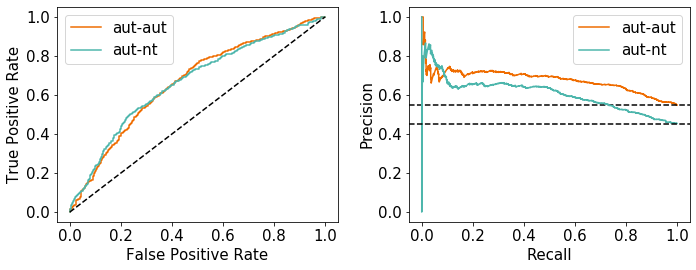

In [22]:
#from patsy import dmatrix

X = np.vstack((sim.T,
               #deletions_match[:, 0]/1000000,
               (deletions_match.T/1000000) * proband_is_f * sibling_is_f,
               (deletions_match.T/1000000) * proband_is_f * ~sibling_is_f,
               (deletions_match.T/1000000) * ~proband_is_f * sibling_is_f,
               (deletions_match.T/1000000) * ~proband_is_f * ~sibling_is_f,

               #(deletions_match[:, 1]/1000000) * ~proband_is_f * ~sibling_is_f,
               #(deletions_match[:, 1]/1000000) * (proband_is_f | sibling_is_f),
               #(deletions_match[:, 1]/1000000) * sibling_is_f,
               proband_is_f * sibling_is_f,
               proband_is_f * ~sibling_is_f,
               ~proband_is_f * sibling_is_f,
               ~proband_is_f * ~sibling_is_f,
               #np.ones((len(sibpairs), ))
                  )).T
y = is_aut_aut

names = ['mat_genomic_similarity', 'pat_genomic_similarity',
                    'mat_match_del + proband_f + sibling_f', 'pat_match_del + proband_f + sibling_f',
                    'mat_match_del + proband_f + sibling_m', 'pat_match_del + proband_f + sibling_m',
                    'mat_match_del + proband_m + sibling_f', 'pat_match_del + proband_m + sibling_f',
                    'mat_match_del + proband_m + sibling_m', 'pat_match_del + proband_m + sibling_m',
                    #'match_del + proband_f + sibling_f',
                    #'match_del + proband_f + sibling_m',
                    #'match_del + proband_m + sibling_f',
                    #'match_del + proband_m + sibling_m',
                    
                       'proband_f + sibling_f', 'proband_f + sibling_m', 'proband_m + sibling_f', 'proband_m + sibling_m' 
                        #'const'
                      ]
#X = np.vstack((mat_sim, pat_sim, mat_jaccard, pat_jaccard, np.ones((len(sibpairs), )))).T[mat_has_data & pat_has_data, :]
#y = is_aut_aut[mat_has_data & pat_has_data] | is_nt_nt[mat_has_data & pat_has_data]

model = sm.Logit(y, X)
model.exog_names[:] = names
result = model.fit()
pvalues = result.pvalues
        

print(stats.chi2(len(result.params)-len(baseline_result.params)).sf(-2*(baseline_result.llf-result.llf)))
print(result.summary())

matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
#sensitivity, specificity, _ = roc_curve(y==2, result.predict(X)[:, 2])
#plt.plot(sensitivity, specificity, label='aut-aut')

sensitivity, specificity, _ = roc_curve(y==1, result.predict(X))
plt.plot(sensitivity, specificity, label='aut-aut', color=colors[0])
sensitivity, specificity, _ = roc_curve(y==0, 1-result.predict(X))
plt.plot(sensitivity, specificity, label='aut-nt', color=colors[1])



plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.subplot(1, 2, 2)
#precision, recall, _ = precision_recall_curve(y==2, result.predict(X)[:, 2])
#plt.plot(recall, precision, label='aut-aut')
#plt.axhline(np.sum(y==2)/len(y), color='black', linestyle='--')

precision, recall, _ = precision_recall_curve(y==1, result.predict(X))
plt.plot(recall, precision, label='aut-aut', color=colors[0])
plt.axhline(np.sum(y==1)/len(y), color='black', linestyle='--')

precision, recall, _ = precision_recall_curve(y==0, 1-result.predict(X))
plt.plot(recall, precision, label='aut-nt', color=colors[1])
plt.axhline(np.sum(y==0)/len(y), color='black', linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')



plt.legend()

plt.tight_layout()
plt.show()

#baseline_result = result

In [23]:
print(result.params[2], np.exp(result.params[2]), 
      np.exp(result.params[2]-result.bse[2]),
      np.exp(result.params[2]+result.bse[2]))

print(result.params[3], np.exp(result.params[3]), 
      np.exp(result.params[3]-result.bse[3]),
      np.exp(result.params[3]+result.bse[3]))


0.6795565661857723 1.9730026421354343 1.488460326907261 2.6152792624051866
-0.5127137087928918 0.5988682177706207 0.4365778951509408 0.8214871761470279


In [24]:
indices = np.hstack((np.random.choice(np.where(proband_is_f & sibling_is_f)[0], size=np.sum(proband_is_f & sibling_is_f)),
                     np.random.choice(np.where(proband_is_f & ~sibling_is_f)[0], size=np.sum(proband_is_f & ~sibling_is_f)),
                     np.random.choice(np.where(~proband_is_f & sibling_is_f)[0], size=np.sum(~proband_is_f & sibling_is_f)),
                     np.random.choice(np.where(~proband_is_f & ~sibling_is_f)[0], size=np.sum(~proband_is_f & ~sibling_is_f)),
                    ))
print(indices.shape)


(1923,)


In [25]:
pvalues, reverse_pvalues = [], []
coeffs, reverse_coeffs = [], []

for i in range(1000):
    sibpairs, sim, deletions_match, proband_deletions, sibling_deletions, \
            is_aut_aut, proband_is_f, sibling_is_f, \
            reverse_sibpairs, reverse_sim, reverse_deletions_match, reverse_proband_deletions, reverse_sibling_deletions, \
            reverse_is_nt_nt, reverse_proband_is_f, reverse_sibling_is_f = get_matches(fam_to_inds, child_id_to_affected, child_id_to_sex, deletions, sibpair_to_sim)

    X = np.vstack((sim.T,
               (deletions_match.T/1000000) * proband_is_f * sibling_is_f,
               (deletions_match.T/1000000) * proband_is_f * ~sibling_is_f,
               (deletions_match.T/1000000) * ~proband_is_f * sibling_is_f,
               (deletions_match.T/1000000) * ~proband_is_f * ~sibling_is_f,
               proband_is_f * sibling_is_f,
               proband_is_f * ~sibling_is_f,
               ~proband_is_f * sibling_is_f,
               ~proband_is_f * ~sibling_is_f,
                  )).T
    y = is_aut_aut
    
    indices = np.hstack((np.random.choice(np.where(proband_is_f & sibling_is_f)[0], size=np.sum(proband_is_f & sibling_is_f)),
                     np.random.choice(np.where(proband_is_f & ~sibling_is_f)[0], size=np.sum(proband_is_f & ~sibling_is_f)),
                     np.random.choice(np.where(~proband_is_f & sibling_is_f)[0], size=np.sum(~proband_is_f & sibling_is_f)),
                     np.random.choice(np.where(~proband_is_f & ~sibling_is_f)[0], size=np.sum(~proband_is_f & ~sibling_is_f)),
                    ))

    model = sm.Logit(y[indices], X[indices, :])
    result = model.fit()
    
    pvalues.append(result.pvalues)
    coeffs.append(result.params)
    
    #X = np.vstack((reverse_sim.T,
    #           (reverse_deletions_match.T/1000000) * reverse_proband_is_f * reverse_sibling_is_f,
    #           (reverse_deletions_match.T/1000000) * reverse_proband_is_f * ~reverse_sibling_is_f,
    #           (reverse_deletions_match.T/1000000) * ~reverse_proband_is_f * reverse_sibling_is_f,
    #           (reverse_deletions_match.T/1000000) * ~reverse_proband_is_f * ~reverse_sibling_is_f,
    ##           reverse_proband_is_f * reverse_sibling_is_f,
     #          reverse_proband_is_f * ~reverse_sibling_is_f,
    ##           ~reverse_proband_is_f * reverse_sibling_is_f,
    #           ~reverse_proband_is_f * ~reverse_sibling_is_f,
    #              )).T
    #y = reverse_is_nt_nt
    #
    #model = sm.Logit(y, X)
    #result = model.fit()
    #
    #reverse_pvalues.append(result.pvalues)
    #reverse_coeffs.append(result.params)


sibpairs 2044 reverse_sibpairs 941
sim outliers 115 109
sim outliers 11 9
child outliers 32


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:110: RuntimeWarning: divide by zero encountered in log10


ValueError: too many values to unpack (expected 16)

In [26]:
pvalues = np.array(pvalues)
#reverse_pvalues = np.array(reverse_pvalues)

coeffs = np.array(coeffs)
#reverse_coeffs = np.array(reverse_coeffs)

ValueError: zero-size array to reduction operation minimum which has no identity

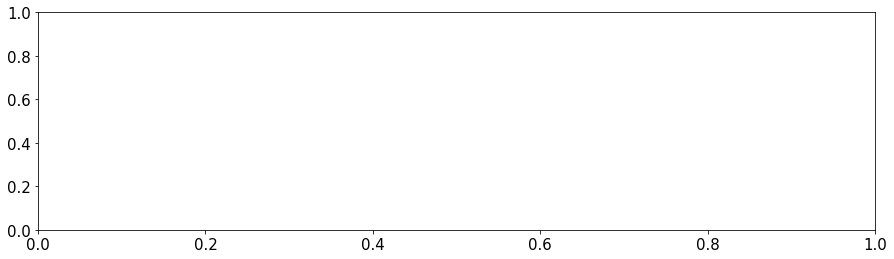

In [27]:

fig = plt.figure(figsize=(15, 4))

#ax = plt.subplot(1, 3, 1)
parts = plt.violinplot(np.log10(pvalues), showmedians=True, showextrema=False)
plt.axhline(np.log10(0.05), color='black', linestyle='--')
plt.xticks(np.arange(1, 15), ['maternal', 'paternal',
                       'maternal', 'paternal',
                       'maternal', 'paternal',
                       'maternal', 'paternal',
                       'maternal', 'paternal',
                       'F-proband\nF-sibling', 'F-proband\nM-sibling', 'M-proband\nF-sibling', 'M-proband\nM-sibling'
                      ], rotation=90)
plt.text(0.65, -0.1, 'Genomic\nSimilarity')
plt.text(2.65, 0.15, 'Shared Deletion Burden (in Mbp)')
plt.text(10.65, 0.15, 'Offset')

plt.text(3.5, -5, 'F-proband\nF-sibling', ha='center')
plt.text(5.5, -5, 'F-proband\nM-sibling', ha='center')
plt.text(7.5, -5, 'M-proband\nF-sibling', ha='center')
plt.text(9.5, -5, 'M-proband\nM-sibling', ha='center')

plt.text(3, np.median(np.log10(pvalues[:, 2]))-0.7, 'odds-ratio\n%0.2f' % np.exp(np.median(coeffs[:, 2])), 
         ha='center', bbox=dict(facecolor='white', alpha=0.75))
plt.text(10, np.median(np.log10(pvalues[:, 9]))-0.7, 'odds-ratio\n%0.2f' % np.exp(np.median(coeffs[:, 9])), 
         ha='center', bbox=dict(facecolor='white', alpha=0.75))
plt.text(11, np.median(np.log10(pvalues[:, 10]))+0.7, 'odds-ratio\n%0.2f' % np.exp(np.median(coeffs[:, 10])), 
         ha='center', bbox=dict(facecolor='white', alpha=0.75))
plt.text(13, np.median(np.log10(pvalues[:, 12]))+0.9, 'odds-ratio\n%0.2f' % np.exp(np.median(coeffs[:, 12])), 
         ha='center', bbox=dict(facecolor='white', alpha=0.75))

plt.axvline(2.5, color='black')
plt.axvline(10.5, color='black')

plt.yticks(np.arange(-3, 1), ['1' if d==0 else '$10^{%d}$' % d for d in np.arange(-3, 1)])
plt.ylim([-3, 0.5])
plt.xlim([0.5, 14.5])
plt.ylabel('p-value')

for pc, x in zip(parts['bodies'], np.median(pvalues, axis=0)):
    pc.set_facecolor(colors[0] if x<0.05 else colors[1])
    pc.set_edgecolor(colors[0] if x<0.05 else colors[1])
    pc.set_alpha(1)
parts['cmedians'].set_edgecolor('black')
parts['cmedians'].set_linewidth(2)

plt.show()
#fig.savefig('../plots/delburden.png', dpi=fig.dpi, bbox_inches='tight')


In [28]:
print(np.sum(pvalues[:, 2]<0.05)/pvalues.shape[0],
      (np.sum(coeffs[:, 2]>0)/coeffs.shape[0])*2,
      (np.sum(coeffs[:, 2]<0)/coeffs.shape[0])*2)
print(np.sum(pvalues[:, 3]<0.05)/pvalues.shape[0],
      (np.sum(coeffs[:, 3]>0)/coeffs.shape[0])*2,
      (np.sum(coeffs[:, 3]<0)/coeffs.shape[0])*2)
print(np.sum(pvalues[:, 9]<0.05)/pvalues.shape[0],
      (np.sum(coeffs[:, 9]>0)/coeffs.shape[0])*2,
      (np.sum(coeffs[:, 9]<0)/coeffs.shape[0])*2)

plt.hist(np.log10(pvalues[:, 2]), alpha=0.5, bins=np.arange(-5, 0.1, 0.1))
plt.hist(np.log10(pvalues[:, 9]), alpha=0.5, bins=np.arange(-5, 0.1, 0.1))
plt.axvline(np.log10(0.05), color='black', linestyle='--')
plt.show()

IndexError: too many indices for array

In [29]:
print(np.sum(is_aut_aut), np.sum(is_aut_nt))

NameError: name 'is_aut_nt' is not defined

ValueError: zero-size array to reduction operation minimum which has no identity

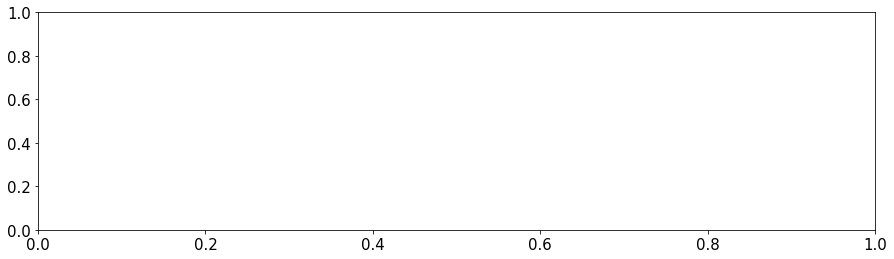

In [30]:

fig = plt.figure(figsize=(15, 4))

#ax = plt.subplot(1, 3, 1)
parts = plt.violinplot(coeffs, showmedians=True, showextrema=False)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(np.arange(1, 15), ['maternal', 'paternal',
                       'maternal', 'paternal',
                       'maternal', 'paternal',
                       'maternal', 'paternal',
                       'maternal', 'paternal',
                       'F-autistic sibling\nF-child', 'F-autistic sibling\nM-child', 
                              'M-autistic sibling\nF-child', 'M-autistic sibling\nM-child'
                      ], rotation=90)
plt.text(0.65, 1.65, 'Genomic\nSimilarity', bbox=dict(facecolor='white', alpha=0.75, linewidth=0))
plt.text(2.65, 2.05, 'Shared Deletion Burden (in Mbp)', bbox=dict(facecolor='white', alpha=0.75, linewidth=0))
plt.text(10.65, 2.05, 'Offset', bbox=dict(facecolor='white', alpha=0.75, linewidth=0))

plt.text(3.5, -5.5, 'F-autistic\nsibling\nF-child', ha='center')
plt.text(5.5, -5.5, 'F-autistic\nsibling\nM-child', ha='center')
plt.text(7.5, -5.5, 'M-autistic\nsibling\nF-child', ha='center')
plt.text(9.5, -5.5, 'M-autistic\nsibling\nM-child', ha='center')

plt.text(3, np.median(coeffs[:, 2])-1.8, 'odds-ratio: %0.2f [%0.2f, %0.2f]\npvalue: %0.3f' % (np.exp(np.median(coeffs[:, 2])),
                                                                                              np.exp(np.quantile(coeffs[:, 2], 0.025)),
                                                                                              np.exp(np.quantile(coeffs[:, 2], 0.975)),
                                                                                              np.sum(coeffs[:, 2]<=0)/coeffs.shape[0],
                                                                              ), 
         ha='center', bbox=dict(facecolor='white', alpha=0.75))
plt.text(10, np.median(coeffs[:, 9])-1.5, 'odds-ratio: %0.2f [%0.2f, %0.2f]\npvalue: %0.3f' % (np.exp(np.median(coeffs[:, 9])),
                                                                                               np.exp(np.quantile(coeffs[:, 9], 0.025)),
                                                                                               np.exp(np.quantile(coeffs[:, 9], 0.975)),
                                                                                               np.sum(coeffs[:, 9]<=0)/coeffs.shape[0],
                                                                               ), 
         ha='center', bbox=dict(facecolor='white', alpha=0.75))

#plt.text(11, np.median(coeffs[:, 10])+2.8, 'odds-ratio: %0.2f [%0.2f, %0.2f]\npvalue: %0.3f' % (np.exp(np.median(coeffs[:, 10])),
#                                                                                                np.exp(np.quantile(coeffs[:, 10], 0.025)),
#                                                                                                np.exp(np.quantile(coeffs[:, 10], 0.975)),
#                                                                                                np.sum(coeffs[:, 10]>=0)/coeffs.shape[0],
#                                                                               ), 
#         ha='center', bbox=dict(facecolor='white', alpha=0.75))
#plt.text(13, np.median(coeffs[:, 12])+1.9, 'odds-ratio: %0.2f [%0.2f, %0.2f]\npvalue: %0.3f' % (np.exp(np.median(coeffs[:, 12])),
#                                                                                                np.exp(np.quantile(coeffs[:, 12], 0.025)),
#                                                                                                np.exp(np.quantile(coeffs[:, 12], 0.975)),
#                                                                                                np.sum(coeffs[:, 12]>=0)/coeffs.shape[0],
#                                                                               ), 
#         ha='center', bbox=dict(facecolor='white', alpha=0.75))

plt.axvline(2.5, color='black')
plt.axvline(10.5, color='black')

plt.ylim([-2.5, 2.5])
plt.xlim([0.5, 14.5])
plt.ylabel('odds ratio')
plt.yticks(np.log([1/10, 1/5, 0.5, 1, 2, 5, 10]), ['1/10', '1/5', '1/2', 1, 2, 5, 10])

# we expect being more similar to the autistic sibling to make the child more likely to be autistic
for pc, x in zip(parts['bodies'][:-4], (np.sum(coeffs<=0, axis=0)/coeffs.shape[0])[:-4]):
    pc.set_facecolor(colors[0] if x<0.05 else colors[1])
    pc.set_edgecolor(colors[0] if x<0.05 else colors[1])
    pc.set_alpha(1)
    
# because we have more aut-aut sibpairs than aut-nt sibpairs, we expect offsets to be negative
for pc, x in zip(parts['bodies'][-4:], (np.sum(coeffs>=0, axis=0)/coeffs.shape[0])[-4:]):
    pc.set_facecolor(colors[0] if x<0.05 else colors[1])
    pc.set_edgecolor(colors[0] if x<0.05 else colors[1])
    pc.set_alpha(1)
parts['cmedians'].set_edgecolor('black')
parts['cmedians'].set_linewidth(2)


#plt.show()
fig.savefig('../plots/delburden.png', dpi=fig.dpi, bbox_inches='tight')


In [31]:
print(stats.ttest_rel(ssc_deletions_match[ssc_proband_is_f & ssc_sibling_is_f, 0], 
                ssc_deletions_match[ssc_proband_is_f & ssc_sibling_is_f, 1]))
print(stats.ttest_rel(ssc_deletions_match[ssc_proband_is_f & ~ssc_sibling_is_f, 0], 
                ssc_deletions_match[ssc_proband_is_f & ~ssc_sibling_is_f, 1]))
print(stats.ttest_rel(ssc_deletions_match[~ssc_proband_is_f & ssc_sibling_is_f, 0], 
                ssc_deletions_match[~ssc_proband_is_f & ssc_sibling_is_f, 1]))
print(stats.ttest_rel(ssc_deletions_match[~ssc_proband_is_f & ~ssc_sibling_is_f, 0], 
                ssc_deletions_match[~ssc_proband_is_f & ~ssc_sibling_is_f, 1]))


Ttest_relResult(statistic=1.0110094504342715, pvalue=0.3138072476194747)
Ttest_relResult(statistic=-0.5122684213978986, pvalue=0.6094455993203596)
Ttest_relResult(statistic=0.2833277592648926, pvalue=0.7769928494189918)
Ttest_relResult(statistic=0.19845669345343672, pvalue=0.8427390180088818)


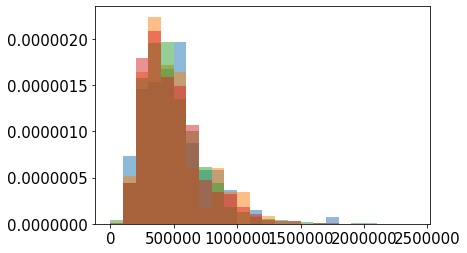

In [32]:
plt.hist(ssc_deletions_match[ssc_proband_is_f & ssc_sibling_is_f, 0], alpha=0.5, bins=np.arange(0, 2500000, 100000), 
        density=True)
plt.hist(ssc_deletions_match[ssc_proband_is_f & ~ssc_sibling_is_f, 0], alpha=0.5, bins=np.arange(0, 2500000, 100000), 
        density=True)
plt.hist(ssc_deletions_match[~ssc_proband_is_f & ssc_sibling_is_f, 0], alpha=0.5, bins=np.arange(0, 2500000, 100000),
        density=True)
plt.hist(ssc_deletions_match[~ssc_proband_is_f & ~ssc_sibling_is_f, 0], alpha=0.5, bins=np.arange(0, 2500000, 100000),
        density=True)

plt.show()

Ttest_indResult(statistic=-0.6995583433849577, pvalue=0.48438352681534425)


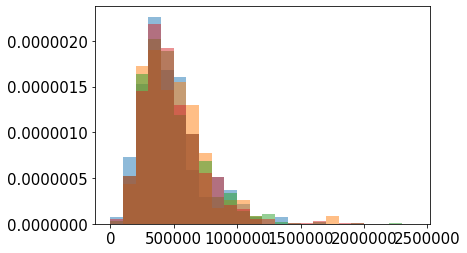

In [33]:
plt.hist(ssc_deletions_match[ssc_proband_is_f & ssc_sibling_is_f, 1], alpha=0.5, bins=np.arange(0, 2500000, 100000), 
        density=True)
plt.hist(ssc_deletions_match[ssc_proband_is_f & ~ssc_sibling_is_f, 1], alpha=0.5, bins=np.arange(0, 2500000, 100000), 
        density=True)
plt.hist(ssc_deletions_match[~ssc_proband_is_f & ssc_sibling_is_f, 1], alpha=0.5, bins=np.arange(0, 2500000, 100000),
        density=True)
plt.hist(ssc_deletions_match[~ssc_proband_is_f & ~ssc_sibling_is_f, 1], alpha=0.5, bins=np.arange(0, 2500000, 100000),
        density=True)
print(stats.ttest_ind(ssc_deletions_match[~ssc_proband_is_f & ~ssc_sibling_is_f, 1], 
                      ssc_deletions_match[ssc_proband_is_f & ~ssc_sibling_is_f, 1]))
plt.show()

Ttest_indResult(statistic=0.22010983256357472, pvalue=0.8258301859872977)


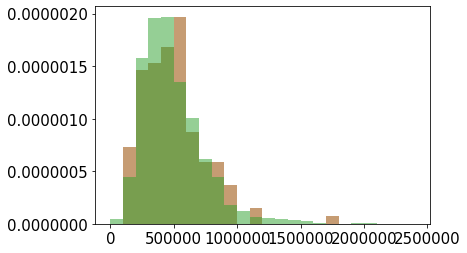

In [34]:
plt.hist(ssc_deletions_match[ssc_proband_is_f & ssc_sibling_is_f, 0], alpha=0.5, bins=np.arange(0, 2500000, 100000), 
        density=True)
plt.hist(ssc_deletions_match[ssc_proband_is_f & ssc_sibling_is_f, 0], alpha=0.5, bins=np.arange(0, 2500000, 100000), 
        density=True)
plt.hist(ssc_deletions_match[~ssc_proband_is_f & ssc_sibling_is_f, 0], alpha=0.5, bins=np.arange(0, 2500000, 100000),
        density=True)

print(stats.ttest_ind(ssc_deletions_match[ssc_proband_is_f & ssc_sibling_is_f, 0], 
                      ssc_deletions_match[~ssc_proband_is_f & ssc_sibling_is_f, 0]))
plt.show()

In [35]:
ssc_X = np.vstack((ssc_sim.T,
               #deletions_match[:, 0]/1000000,
               (ssc_deletions_match.T/1000000) * ssc_proband_is_f * ssc_sibling_is_f,
               (ssc_deletions_match.T/1000000) * ssc_proband_is_f * ~ssc_sibling_is_f,
               (ssc_deletions_match.T/1000000) * ~ssc_proband_is_f * ssc_sibling_is_f,
               (ssc_deletions_match.T/1000000) * ~ssc_proband_is_f * ~ssc_sibling_is_f,

               #(deletions_match[:, 1]/1000000) * ~proband_is_f * ~sibling_is_f,
               #(deletions_match[:, 1]/1000000) * (proband_is_f | sibling_is_f),
               #(deletions_match[:, 1]/1000000) * sibling_is_f,
               ssc_proband_is_f * ssc_sibling_is_f,
               ssc_proband_is_f * ~ssc_sibling_is_f,
               ~ssc_proband_is_f * ssc_sibling_is_f,
               ~ssc_proband_is_f * ~ssc_sibling_is_f,
               #np.ones((len(sibpairs), ))
                  )).T
pred = result.predict(ssc_X)

In [36]:
print(pred.shape)

(1914,)


(array([ 17.,  56., 165., 280., 225., 109.,  39.,   8.,   3.,   2.]),
 array([0.55548893, 0.57658743, 0.59768593, 0.61878443, 0.63988293,
        0.66098143, 0.68207993, 0.70317843, 0.72427693, 0.74537543,
        0.76647393]),
 <a list of 10 Patch objects>)

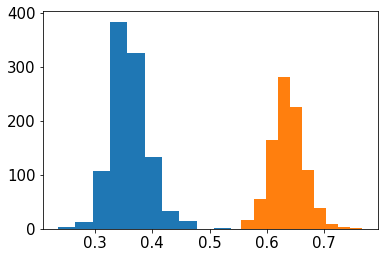

In [37]:
plt.hist(pred[ssc_sibling_is_f])
plt.hist(pred[~ssc_sibling_is_f])

In [38]:
print(len(ssc_sibpairs))

1914


In [39]:
print(np.sum(ssc_proband_is_f & ssc_sibling_is_f), np.sum(~ssc_proband_is_f & ~ssc_sibling_is_f))

137 788


In [40]:
aut_phen = np.zeros((len(sibpairs), 3))
nt_phen = np.zeros((len(sibpairs), 3))
nt_to_index = dict([(x, i) for i, (fam, x) in enumerate(siblings)])
aut_to_index = dict([(x, i) for i, (fam, x) in enumerate(probands)])
with open('../phenotypes/ihart/Vineland/VINE1_new.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    print(header)
    
    # Comm_Standard_Score DLS_Standard_Score Soc_Standard_Score 
    id_index = header.index('Individual ID')
    phen_indices = [header.index('Comm_Standard_Score'), header.index('DLS_Standard_Score'), header.index('Soc_Standard_Score')]
    for pieces in reader:
        if pieces[id_index] in nt_to_index:
            nt_phen[nt_to_index[pieces[id_index]], :] = [0 if pieces[phen_index]=='' or pieces[phen_index]=='-1' else float(pieces[phen_index]) for phen_index in phen_indices]
        if pieces[id_index] in aut_to_index:
            nt_phen[aut_to_index[pieces[id_index]], :] = [0 if pieces[phen_index]=='' or pieces[phen_index]=='-1' else float(pieces[phen_index]) for phen_index in phen_indices]
    
#nt_phen[nt_phen==20] = 0
print(np.sum((nt_phen!=0), axis=0)/len(nt_phen))
    

['FormID', 'Version', 'PatientNum', 'ProjectNum', 'ProjectName', 'Gender', 'Individual ID', 'data_entry_date', 'original_source_name', ' original_source_id', 'AU/Family ID', 'NDAR_GUID', 'Status', 'InterviewMonth', 'InterviewDay', 'InterviewYear', 'age', 'Interviewernum', 'Interviewer_Org', 'Validated', 'Communication_v_Scale_Sum', 'Comm_Standard_Score_EQ_LT_GT', 'Comm_Standard_Score', 'Comm_Standard_Cmb', 'Communication_90_CI', 'Comm_Percentile_Rank_EQ_LT_GT', 'Comm_Percentile_Rank', 'Comm_Percentile_Rank_Cmb', 'Comm_Adaptive_Level', 'Comm_Stanine', 'Communication_Score_Minus_Medi', 'Communication_S_W', 'DLS_v_Scale_Sum', 'DLS_Standard_Score_EQ_LT_GT', 'DLS_Standard_Score', 'DLS_Standard_Score_Cmb', 'DLS_90_CI', 'DLS_Percentile_Rank_EQ_LT_GT', 'DLS_Percentile_Rank', 'DLS_Percentile_Rank_Cmb', 'DLS_Adaptive_Level', 'DLS_Stanine', 'DLS_Score_Minus_Median', 'DLS_S_W', 'Soc_v_Scale_Sum', 'Soc_Standard_Score_EQ_LT_GT', 'Soc_Standard_Score', 'Soc_Standard_Score_Cmb', 'Soc_90_CI', 'Soc_Perce

(array([719.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  25.,   0.,
          2.,   2.,  10.,   3.,   0.,   1.,   1.,   0.,   2.,   2.,   2.,
          1.,  10.,   4.,   2.,   6.,   5.,   3.,   6.,   0.,  11.,   5.,
          9.,  13.,  16.,  12.,  26.,  13.,  34.,  47.,  21.,  41.,  12.,
         39.,   6.,  37.,  15.,  32.,  12.,  43.,  36.,  19.,  32.,  21.,
         30.,   9.,  48.,  26.,  27.,  33.,  19.,  37.,  19.,  40.,  25.,
         16.,  21.,  16.,  18.,   9.,  26.,  17.,   4.,  33.,  12.,   7.,
         10.,   4.,   7.,   8.,   5.,   2.,  11.,   3.,   3.,   0.,   1.,
          0.,   4.,   1.,   0.,   1.,   1.,   1.,   4.,   0.,   0.,   2.,
          1.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  3

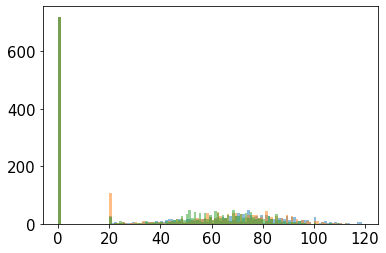

In [41]:
plt.hist(nt_phen[:, 0], alpha=0.5, bins=np.arange(0, 120))
plt.hist(nt_phen[:, 1], alpha=0.5, bins=np.arange(0, 120))
plt.hist(nt_phen[:, 2], alpha=0.5, bins=np.arange(0, 120))

(0.16280870603557257, 0.0006623657006866118)
(-0.02573418274111181, 0.6475454150458942)
(0.03768568819894048, 0.4335640596815747)
(0.024652246470687204, 0.6614240329393118)
(0.1336141804510501, 0.007527466278691574)
(-0.01788088957234065, 0.7546169684253607)
(0.06529416271941313, 0.19307120883995646)
(0.06367182675810591, 0.2652692261810767)
(0.16280395010307985, 0.0006531083318672189)
(0.016197953457860292, 0.7739010491362927)
(0.03449612605610942, 0.4729933722616303)
(0.09589396531256976, 0.08828230293541459)


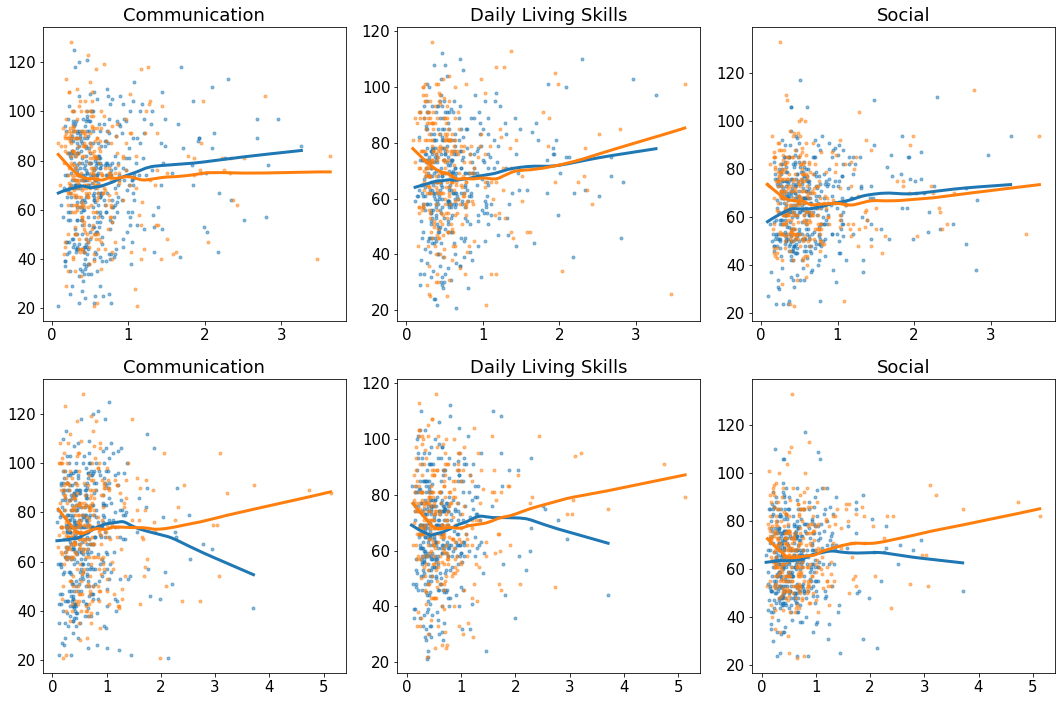

In [42]:
plt.figure(figsize=(15, 10))

titles = ['Communication', 'Daily Living Skills', 'Social']

for i in range(3):
    plt.subplot(2, 3, i+1)
    indices = ~proband_is_f & ~sibling_is_f & is_aut_aut & (nt_phen[:, i]>20)
    plt.scatter(deletions_match[indices, 1]/1000000, nt_phen[indices, i], marker='.', alpha=0.5)
    l = sm.nonparametric.lowess(nt_phen[indices, i], deletions_match[indices, 1]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3)
    print(stats.pearsonr(deletions_match[indices, 1]/1000000, nt_phen[indices, i]))

    indices = (proband_is_f | sibling_is_f) & is_aut_aut & (nt_phen[:, i]>20)
    plt.scatter(deletions_match[indices, 1]/1000000, nt_phen[indices, i], marker='.', alpha=0.5)
    l = sm.nonparametric.lowess(nt_phen[indices, i], deletions_match[indices, 1]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3)
    print(stats.pearsonr(deletions_match[indices, 1]/1000000, nt_phen[indices, i]))
    plt.title(titles[i])
    
    plt.subplot(2, 3, i+4)
    indices = ~proband_is_f & ~sibling_is_f & is_aut_aut & (nt_phen[:, i]>20)
    plt.scatter(deletions_match[indices, 0]/1000000, nt_phen[indices, i], marker='.', alpha=0.5)
    l = sm.nonparametric.lowess(nt_phen[indices, i], deletions_match[indices, 0]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3)
    print(stats.pearsonr(deletions_match[indices, 0]/1000000, nt_phen[indices, i]))

    indices = (proband_is_f | sibling_is_f) & is_aut_aut & (nt_phen[:, i]>20)
    plt.scatter(deletions_match[indices, 0]/1000000, nt_phen[indices, i], marker='.', alpha=0.5)
    l = sm.nonparametric.lowess(nt_phen[indices, i], deletions_match[indices, 0]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3)
    print(stats.pearsonr(deletions_match[indices, 0]/1000000, nt_phen[indices, i]))
    plt.title(titles[i])

plt.tight_layout()
plt.show()

In [43]:
ssc_nt_phen = np.zeros((len(ssc_sibpairs), 4))
ssc_aut_phen = np.zeros((len(ssc_sibpairs), 4))
ssc_mother_phen, ssc_father_phen = np.zeros((len(ssc_sibpairs), 3)), np.zeros((len(ssc_sibpairs), 3))

nt_to_index = dict([(('%s.s1' % fam), i) for i, (fam, x) in enumerate(ssc_sibpairs)])
aut_to_index = dict([(('%s.p1' % fam), i) for i, (fam, x) in enumerate(ssc_sibpairs)])
mother_to_index = dict([(('%s.mo' % fam), i) for i, (fam, x) in enumerate(ssc_sibpairs)])
father_to_index = dict([(('%s.fa' % fam), i) for i, (fam, x) in enumerate(ssc_sibpairs)])

#with open('../phenotypes/ssc/designated.unaffected.sibling.data/ssc_commonly_used.csv', 'r') as f:
with open('../phenotypes/ssc/designated.unaffected.sibling.data/vineland_ii.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    print(header)
    
    # 'vabs_ii_communication', 'vabs_ii_dls_standard', 'vabs_ii_motor_skills', 'vabs_ii_soc_standard'
    phen_indices = [header.index('communication_standard'), header.index('dls_standard'), header.index('soc_standard'), header.index('motor_skills_standard')]
    for pieces in reader:
        if pieces[0] in nt_to_index:
            ssc_nt_phen[nt_to_index[pieces[0]], :] = [0 if pieces[phen_index]=='' or pieces[phen_index]=='-1' else float(pieces[phen_index]) for phen_index in phen_indices]
    
with open('../phenotypes/ssc/proband.data/vineland_ii.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    print(header)
    
    # 'vabs_ii_communication', 'vabs_ii_dls_standard', 'vabs_ii_motor_skills', 'vabs_ii_soc_standard'
    phen_indices = [header.index('communication_standard'), header.index('dls_standard'), header.index('soc_standard'), header.index('motor_skills_standard')]
    for pieces in reader:
        if pieces[0] in aut_to_index:
            ssc_aut_phen[aut_to_index[pieces[0]], :] = [0 if pieces[phen_index]=='' or pieces[phen_index]=='-1' else float(pieces[phen_index]) for phen_index in phen_indices]

with open('../phenotypes/ssc/mother.data/bapq.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    print(header)
    
    phen_indices = [header.index('aloof'), header.index('pragmatic'), header.index('rigid')]
    for pieces in reader:
        if pieces[0] in mother_to_index:
            ssc_mother_phen[mother_to_index[pieces[0]], :] = [0 if pieces[phen_index]=='' or pieces[phen_index]=='-1' else float(pieces[phen_index]) for phen_index in phen_indices]

with open('../phenotypes/ssc/father.data/bapq.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    print(header)
    
    phen_indices = [header.index('aloof'), header.index('pragmatic'), header.index('rigid')]
    for pieces in reader:
        if pieces[0] in father_to_index:
            ssc_father_phen[father_to_index[pieces[0]], :] = [0 if pieces[phen_index]=='' or pieces[phen_index]=='-1' else float(pieces[phen_index]) for phen_index in phen_indices]
    
print(np.sum(ssc_nt_phen!=0, axis=0)/len(ssc_nt_phen))
print(np.sum(ssc_mother_phen!=0, axis=0)/len(ssc_mother_phen))
print(np.sum(ssc_father_phen!=0, axis=0)/len(ssc_father_phen))


['individual', 'measure', 'communication_standard', 'communication_sum', 'community_age_equiv', 'community_raw_score', 'community_v_score', 'composite_standard_score', 'coping_age_equiv', 'coping_raw_score', 'coping_v_score', 'dls_standard', 'dls_sum', 'domestic_age_equiv', 'domestic_raw_score', 'domestic_v_score', 'express_age_equiv', 'expressive_raw_score', 'express_v_score', 'fine_age_equiv', 'fine_raw_score', 'fine_v_score', 'gross_age_equiv', 'gross_raw_score', 'gross_v_score', 'ir_age_equiv', 'ir_raw_score', 'ir_v_score', 'maladaptive_ex_raw_score_index', 'maladaptive_ex_v_score', 'maladaptive_int_raw_score_index', 'maladaptive_int_v_score', 'motor_skills_standard', 'motor_skills_sum', 'personal_age_equiv', 'personal_raw_score', 'personal_v_score', 'plt_age_equiv', 'plt_raw_score', 'plt_v_score', 'receptive_age_equiv', 'receptive_raw_score', 'receptive_v_score', 'soc_standard', 'soc_sum', 'sum_standard', 'written_age_equiv', 'written_raw_score', 'written_v_score']
['individual', 

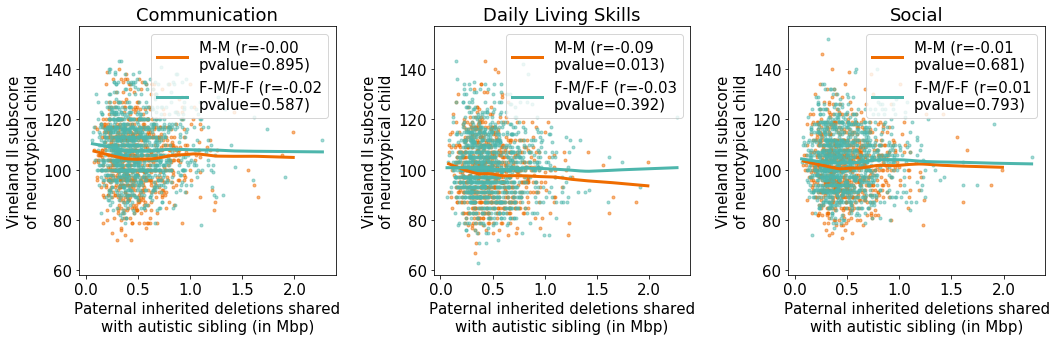

In [62]:
plt.figure(figsize=(15, 5))

titles = ['Communication', 'Daily Living Skills', 'Social']

ax = plt.subplot(1, 3, 1)
for i in range(3):
    plt.subplot(1, 3, i+1, sharex=ax, sharey=ax)
    indices = ~ssc_proband_is_f & ~ssc_sibling_is_f & (ssc_nt_phen[:, i]!=0)
    plt.scatter(ssc_deletions_match[indices, 1]/1000000, ssc_nt_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[0])
    l = sm.nonparametric.lowess(ssc_nt_phen[indices, i], ssc_deletions_match[indices, 1]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='M-M (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(ssc_deletions_match[indices, 1]/1000000, ssc_nt_phen[indices, i]),
            color=colors[0])

    indices = (ssc_proband_is_f | ssc_sibling_is_f) & (ssc_nt_phen[:, i]!=0)
    plt.scatter(ssc_deletions_match[indices, 1]/1000000, ssc_nt_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[1])
    l = sm.nonparametric.lowess(ssc_nt_phen[indices, i], ssc_deletions_match[indices, 1]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='F-M/F-F (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(ssc_deletions_match[indices, 1]/1000000, ssc_nt_phen[indices, i]),
            color=colors[1])
    
    #indices = ~ssc_proband_is_f & ~ssc_sibling_is_f & (ssc_nt_phen[:, i]!=0)
    #plt.scatter(ssc_deletions_match[indices, 0]/1000000, ssc_nt_phen[indices, i], 
    #            marker='.', alpha=0.5, color=colors[2])
    #l = sm.nonparametric.lowess(ssc_nt_phen[indices, i], ssc_deletions_match[indices, 0]/1000000, return_sorted=True)
    #plt.plot(l[:, 0], l[:, 1], linewidth=3, label='M-M Mat(r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(ssc_deletions_match[indices, 0]/1000000, ssc_nt_phen[indices, i]),
    #        color=colors[2])
    
    plt.title(titles[i])
    plt.legend()
    #plt.axhline(100, color='black', linestyle='--')
    plt.xlabel('Paternal inherited deletions shared\nwith autistic sibling (in Mbp)')
    plt.ylabel('Vineland II subscore\nof neurotypical child')

plt.tight_layout()
plt.savefig('../plots/subclinical.png', dpi=fig.dpi, bbox_inches='tight')

#plt.show()

In [80]:
indices = ~ssc_proband_is_f & ~ssc_sibling_is_f & (ssc_nt_phen[:, i]!=0)
#indices = (ssc_nt_phen[:, i]!=0)
X = np.vstack((#ssc_sim.T,
               #ssc_deletions_match.T/1000000,
               ssc_deletions_match[:, 1]/1000000,
               np.ones((len(ssc_sibpairs), ))
                  )).T[indices, :]
y = ssc_nt_phen[indices, 1]

names = [#'mat_genomic_similarity', 'pat_genomic_similarity',
         #'mat_match_del',
    'pat_match_del',
         'const'
                      ]
#X = np.vstack((mat_sim, pat_sim, mat_jaccard, pat_jaccard, np.ones((len(sibpairs), )))).T[mat_has_data & pat_has_data, :]
#y = is_aut_aut[mat_has_data & pat_has_data] | is_nt_nt[mat_has_data & pat_has_data]

model = sm.OLS(y, X)
model.exog_names[:] = names
result = model.fit()
pvalues = result.pvalues
        

print(stats.chi2(len(result.params)-len(baseline_result.params)).sf(-2*(baseline_result.llf-result.llf)))
print(result.summary())

nan
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.256
Date:                Tue, 27 Jul 2021   Prob (F-statistic):             0.0126
Time:                        10:32:59   Log-Likelihood:                -3039.7
No. Observations:                 786   AIC:                             6083.
Df Residuals:                     784   BIC:                             6093.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
pat_match_del    -4.2735      1.709     -2

137
1772
137
137
1772
137
137
1772
137


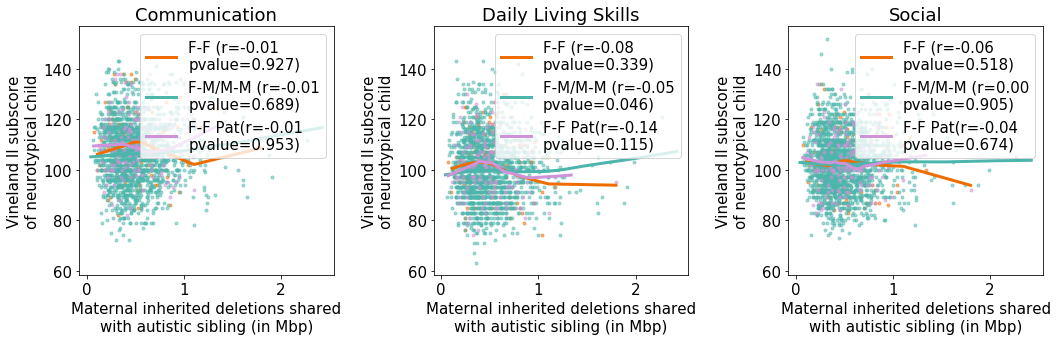

In [64]:
plt.figure(figsize=(15, 5))

titles = ['Communication', 'Daily Living Skills', 'Social']

ax = plt.subplot(1, 3, 1)
for i in range(3):
    plt.subplot(1, 3, i+1, sharex=ax, sharey=ax)
    indices = ssc_proband_is_f & ssc_sibling_is_f & (ssc_nt_phen[:, i]!=0)
    print(np.sum(indices))
    plt.scatter(ssc_deletions_match[indices, 1]/1000000, ssc_nt_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[0])
    l = sm.nonparametric.lowess(ssc_nt_phen[indices, i], ssc_deletions_match[indices, 0]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='F-F (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(ssc_deletions_match[indices, 1]/1000000, ssc_nt_phen[indices, i]),
            color=colors[0])

    indices = (~ssc_proband_is_f | ~ssc_sibling_is_f) & (ssc_nt_phen[:, i]!=0)
    print(np.sum(indices))
    plt.scatter(ssc_deletions_match[indices, 1]/1000000, ssc_nt_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[1])
    l = sm.nonparametric.lowess(ssc_nt_phen[indices, i], ssc_deletions_match[indices, 0]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='F-M/M-M (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(ssc_deletions_match[indices, 1]/1000000, ssc_nt_phen[indices, i]),
            color=colors[1])
    
    indices = ssc_proband_is_f & ssc_sibling_is_f & (ssc_nt_phen[:, i]!=0)
    print(np.sum(indices))
    plt.scatter(ssc_deletions_match[indices, 0]/1000000, ssc_nt_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[2])
    l = sm.nonparametric.lowess(ssc_nt_phen[indices, i], ssc_deletions_match[indices, 1]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='F-F Pat(r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(ssc_deletions_match[indices, 0]/1000000, ssc_nt_phen[indices, i]),
            color=colors[2])
    
    plt.title(titles[i])
    plt.legend()
    #plt.axhline(100, color='black', linestyle='--')
    plt.xlabel('Maternal inherited deletions shared\nwith autistic sibling (in Mbp)')
    plt.ylabel('Vineland II subscore\nof neurotypical child')

plt.tight_layout()

plt.show()

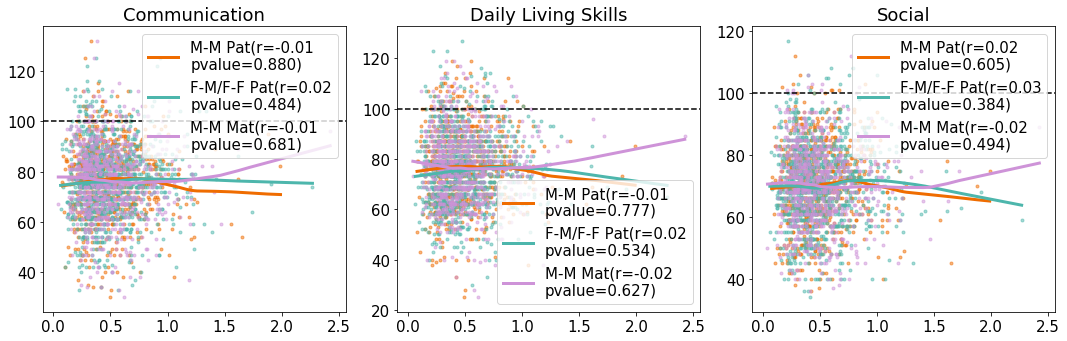

In [45]:
plt.figure(figsize=(15, 5))

titles = ['Communication', 'Daily Living Skills', 'Social']

for i in range(3):
    plt.subplot(1, 3, i+1)
    indices = ~ssc_proband_is_f & ~ssc_sibling_is_f & (ssc_aut_phen[:, i]!=0)
    plt.scatter(ssc_deletions_match[indices, 1]/1000000, ssc_aut_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[0])
    l = sm.nonparametric.lowess(ssc_aut_phen[indices, i], ssc_deletions_match[indices, 1]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='M-M Pat(r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(ssc_deletions_match[indices, 1]/1000000, ssc_aut_phen[indices, i]),
            color=colors[0])

    indices = (ssc_proband_is_f | ssc_sibling_is_f) & (ssc_aut_phen[:, i]!=0)
    plt.scatter(ssc_deletions_match[indices, 1]/1000000, ssc_aut_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[1])
    l = sm.nonparametric.lowess(ssc_aut_phen[indices, i], ssc_deletions_match[indices, 1]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='F-M/F-F Pat(r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(ssc_deletions_match[indices, 1]/1000000, ssc_aut_phen[indices, i]),
            color=colors[1])
    
    indices = ~ssc_proband_is_f & ~ssc_sibling_is_f & (ssc_aut_phen[:, i]!=0)
    plt.scatter(ssc_deletions_match[indices, 0]/1000000, ssc_aut_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[2])
    l = sm.nonparametric.lowess(ssc_aut_phen[indices, i], ssc_deletions_match[indices, 0]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='M-M Mat(r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(ssc_deletions_match[indices, 0]/1000000, ssc_aut_phen[indices, i]),
            color=colors[2])
    
    plt.title(titles[i])
    plt.legend()
    plt.axhline(100, color='black', linestyle='--')
    

plt.tight_layout()
plt.show()

In [302]:
indices = ssc_nt_phen[:, 1] != 0
X = np.vstack((ssc_sim.T,
               #deletions_match[:, 0]/1000000,
               (ssc_deletions_match[:, 1]/1000000) * ssc_proband_is_f * ssc_sibling_is_f,
               (ssc_deletions_match[:, 1]/1000000) * ssc_proband_is_f * ~ssc_sibling_is_f,
               (ssc_deletions_match[:, 1]/1000000) * ~ssc_proband_is_f * ssc_sibling_is_f,
               (ssc_deletions_match[:, 1]/1000000) * ~ssc_proband_is_f * ~ssc_sibling_is_f,

               #(deletions_match[:, 1]/1000000) * ~proband_is_f * ~sibling_is_f,
               #(deletions_match[:, 1]/1000000) * (proband_is_f | sibling_is_f),
               #(deletions_match[:, 1]/1000000) * sibling_is_f,
               ssc_proband_is_f * ssc_sibling_is_f,
               ssc_proband_is_f * ~ssc_sibling_is_f,
               ~ssc_proband_is_f * ssc_sibling_is_f,
               ~ssc_proband_is_f * ~ssc_sibling_is_f,
               #np.ones((len(sibpairs), ))
                  )).T[indices, :]
y = ssc_nt_phen[indices, 1]

names = ['mat_genomic_similarity', 'pat_genomic_similarity',
                   # 'mat_match_del + proband_f + sibling_f', 
         'pat_match_del + proband_f + sibling_f',
                    #'mat_match_del + proband_f + sibling_m', 
         'pat_match_del + proband_f + sibling_m',
                    #'mat_match_del + proband_m + sibling_f', 
         'pat_match_del + proband_m + sibling_f',
                    #'mat_match_del + proband_m + sibling_m', 
         'pat_match_del + proband_m + sibling_m',
                    #'match_del + proband_f + sibling_f',
                    #'match_del + proband_f + sibling_m',
                    #'match_del + proband_m + sibling_f',
                    #'match_del + proband_m + sibling_m',
                    
                       'proband_f + sibling_f', 'proband_f + sibling_m', 'proband_m + sibling_f', 'proband_m + sibling_m' 
                        #'const'
                      ]
#X = np.vstack((mat_sim, pat_sim, mat_jaccard, pat_jaccard, np.ones((len(sibpairs), )))).T[mat_has_data & pat_has_data, :]
#y = is_aut_aut[mat_has_data & pat_has_data] | is_nt_nt[mat_has_data & pat_has_data]

model = sm.OLS(y, X)
model.exog_names[:] = names
result = model.fit()
pvalues = result.pvalues
        

print(stats.chi2(len(result.params)-len(baseline_result.params)).sf(-2*(baseline_result.llf-result.llf)))
print(result.summary())

1.0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.632
Date:                Fri, 16 Jul 2021   Prob (F-statistic):            0.00501
Time:                        07:33:47   Log-Likelihood:                -7412.0
No. Observations:                1909   AIC:                         1.484e+04
Df Residuals:                    1899   BIC:                         1.490e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [304]:
print(result.params[5])

-4.097181212660983
